In [9]:
from datasets import load_dataset
import numpy as np
import re
from matplotlib import pyplot as plt



dataset = load_dataset('json',data_files='data.json').class_encode_column('artist')
artists_mappings = dataset['train'].features['artist'].names

Using custom data configuration default-1a5eae679f892839
Found cached dataset json (C:/Users/tomma/.cache/huggingface/datasets/json/default-1a5eae679f892839/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)
100%|██████████| 1/1 [00:00<00:00, 11.89it/s]
Loading cached processed dataset at C:\Users\tomma\.cache\huggingface\datasets\json\default-1a5eae679f892839\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-425175bc9efee20d.arrow


In [2]:
def clean(example):
    allowed_parts = ['verse','break','chorus','intro', 'interlude', 'bridge', 'outro']
    for part in allowed_parts:
        example['lyrics']=re.sub("\[.*"+part+".*\]", f"[{part}]", example['lyrics'], flags=re.IGNORECASE)
    example['lyrics']=re.sub("\[(?!"+"|".join(allowed_parts)+").*?\]", "", example['lyrics'], flags=re.DOTALL)
    example['lyrics']=re.sub("[0-9]+embed", "", example['lyrics'], flags=re.IGNORECASE)
    return example

mapped_dataset = dataset.map(clean)


100%|██████████| 7185/7185 [00:01<00:00, 6935.33ex/s]


In [3]:
def list_song_parts(example):
    parts = re.findall(r'\[[^\[\]]+\]',example['lyrics']) # Capture everything enclosed in square brackets
    for i,part in enumerate(parts): 
        parts[i] = re.sub(r':.*(?=\])','',part) # Remove everything from : to the closing bracket ] (Most lyrics contain the name of the singer of these parts e.g. [Chorus: 2 Chainz])
    return {'parts': parts}
parts = mapped_dataset['train'].map(list_song_parts,remove_columns=dataset['train'].column_names)

parts:np.ndarray = np.unique([el for l in parts['parts'] for el in l ])

100%|██████████| 7185/7185 [00:00<00:00, 18477.96ex/s]


In [4]:
print(*parts)

[break] [bridge] [chorus] [interlude] [intro] [outro] [verse]


In [5]:
# print(mapped_dataset)
print(dataset['train'][1000]['lyrics'])
print("----------------")
print(mapped_dataset['train'][1000]['lyrics'])

XO TOUR Llif3 Lyrics[Intro]
Are you alright?
I'm alright, I'm quite alright
And my money's right
8… (Yeah)
Countin' them bands
All way to the top 'til they be fallin' over
(Yeah, yeah, yeah)
Countin' them bands
On my way to the top 'til we fallin' over

[Chorus]
I don't really care if you cry
On the real, you shoulda never lied
Shoulda saw the way she looked me in my eyes
She said, "Baby, I am not afraid to die"
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge
All my friends are dead
Push me to the edge

[Verse 1]
Phantom that's all red, inside all white
Like somethin' you ride a sled down, I just want that head
My Brittany got mad, I'm barely her man now
Everybody got the same swag now
Watch the way that I tear it down
Stackin' my bands all the way to the top
All the way 'til my bands fallin' over
Every time that you leave your spot
Your girlfriend call me like, "Come on over!"
I like the way that she treat me
Gon' leave you, 

In [6]:
allowed_parts = ['verse','break','chorus','intro', 'interlude', 'bridge', 'outro']
def contains_one_of(allowed_parts,part:str):
    for p in allowed_parts:
        if p in part.lower(): return True
    return False
filtered_parts = np.unique([part for part in parts if contains_one_of(allowed_parts,part)])

In [7]:
sorted(filtered_parts)

['[break]',
 '[bridge]',
 '[chorus]',
 '[interlude]',
 '[intro]',
 '[outro]',
 '[verse]']

# Preprocessing

In [12]:
def plot_dist(dataset):
    counts = {}
    for example in dataset:
        if example['artist'] not in counts.keys():
            counts[example['artist']] = 0
        else:
            counts[example['artist']] += 1
    plt.bar(counts.keys(), counts.values())

## Train Test Val Split

In [13]:
from datasets import DatasetDict
tts_mapped_dataset = mapped_dataset['train'].train_test_split(train_size=0.7)
mapped_dataset_valid = tts_mapped_dataset['test'].train_test_split(train_size=0.3)

train_test_val_dataset = DatasetDict({
    'train': tts_mapped_dataset['train'],
    'test':mapped_dataset_valid['test'],
    'val': mapped_dataset_valid['train']
    
})

train_test_val_dataset

DatasetDict({
    train: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 5029
    })
    test: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 1510
    })
    val: Dataset({
        features: ['artist', 'lyrics'],
        num_rows: 646
    })
})

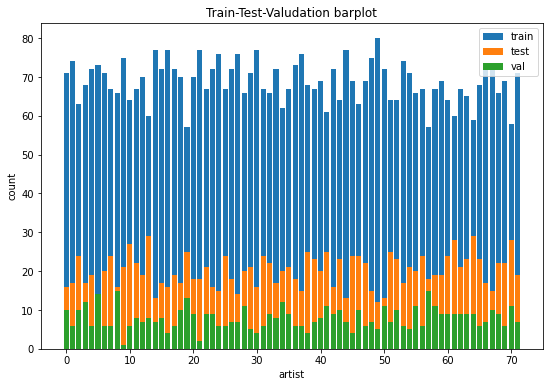

In [18]:
plt.figure(figsize=(9,6))
plt.title("Train-Test-Valudation barplot")
plt.ylabel("count")
plt.xlabel("artist")
plot_dist(train_test_val_dataset['train'])
plot_dist(train_test_val_dataset['test'])
plot_dist(train_test_val_dataset['val'])
plt.legend(['train', 'test', 'val'])
plt.show()

## Machine Learning

In [38]:
from transformers import AutoModel, AutoTokenizer

# Language Model and Tokenizer Declaration:

modelckpt="bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(modelckpt)
model = AutoModel.from_pretrained(modelckpt)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
# Tokenize
def prepare_train_features(examples):
    tokenized_examples = tokenizer(
        examples['lyrics'],
        truncation=True,
        padding=True,
        max_length=512
        )
    tokenized_examples['labels'] = examples['artist']
    return tokenized_examples

train_features = train_test_val_dataset['train'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["train"].column_names).with_format('torch')
test_features = train_test_val_dataset['test'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["test"].column_names).with_format('torch')
val_features = train_test_val_dataset['val'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["val"].column_names).with_format('torch')

100%|██████████| 6/6 [00:04<00:00,  1.39ba/s]
Loading cached processed dataset at C:\Users\tomma\.cache\huggingface\datasets\json\default-1a5eae679f892839\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-54484fee37c60955.arrow
Loading cached processed dataset at C:\Users\tomma\.cache\huggingface\datasets\json\default-1a5eae679f892839\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-ce23a64fd2874b35.arrow


In [21]:
! pip install pytorch_metric_learning
from pytorch_metric_learning import distances, losses, miners, reducers, testers


     -------------------------------------- 109.3/109.3 KB 6.2 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\tomma\Documents\Uni\Magistrale\pyvenvs\ML_venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [55]:
# # This was made by ChatGPT, keep an eye for possible bugs

# import torch
# import transformers
# from torch.utils.data import DataLoader
# from torch.utils.data import Dataset
# from transformers import AdamW
# from transformers import get_linear_schedule_with_warmup
# from transformers import AutoTokenizer, AutoModel,AutoConfig

# # Define your dataset and data loader
# class SimpleDataset(Dataset):
#     def __init__(self, data, tokenizer):
#         self.data = data
#         self.tokenizer = tokenizer

#     def __getitem__(self, index):
#         item = {key: torch.tensor(val[index]) for key, val in self.data.items()}
#         return item

#     def __len__(self):
#         return len(self.data['input_ids'])

# # Define your triplet loss function
# class TripletLoss(torch.nn.Module):
#     def __init__(self, margin=1.0):
#         super(TripletLoss, self).__init__()
#         self.margin = margin

#     def forward(self, anchor, positive, negative):
#         dist_pos = torch.norm(anchor - positive, p=2, dim=1)
#         dist_neg = torch.norm(anchor - negative, p=2, dim=1)
#         loss = torch.mean(torch.relu(dist_pos - dist_neg + self.margin))
#         return loss
    
# # Define your model
# class TransformerModel(torch.nn.Module):
#     def __init__(self, model_name):
#         super(TransformerModel, self).__init__()
#         self.transformer = AutoModel.from_pretrained(model_name)
#         self.dense_layer = torch.nn.Linear(self.transformer.config.hidden_size, self.transformer.config.hidden_size)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.transformer(input_ids, attention_mask)
#         pooled_output = outputs[1]
#         embeddings = self.dense_layer(pooled_output)
#         return embeddings



# # Load your pre-trained model and define your model
# model_name = 'bert-base-uncased'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = TransformerModel(model_name)

# # # Freeze all the parameters in the pre-trained model
# for param in model.parameters():
#     param.requires_grad = False

# Set the model to training mode



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

device = 'cpu'
if torch.cuda.is_available():
    device='cuda'

model = model.to(device)
# # Freeze all the parameters in the pre-trained model
# for param in model.parameters():
#     param.requires_grad = False

# Define training hyperparameters
learning_rate = 2e-5
epochs = 3
batch_size = 32

# Define your training data
train_loader = DataLoader(train_features,batch_size=8)

# Define your optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    # Train your model
    for batch_idx,batch in enumerate(train_loader):
        # Extract the input ids and attention masks from the batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Encode the inputs using the pre-trained model
        embeddings = model(input_ids=input_ids, attention_mask=attention_mask)

        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}:  Number of mined triplets = {}".format(
                    epoch, batch_idx, mining_func.num_triplets
                )
            )

    # Print the loss every epoch
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

In [47]:
margin = 0.1
loss_func = losses.TripletMarginLoss(margin=margin) # triplet loss with margin 0.1
mining_func = miners.TripletMarginMiner(margin=margin, type_of_triplets="semihard") # use semihard mining

num_epochs = 1 # train for 1 epoch

for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)

KeyboardInterrupt: 